In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv

import random
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.python.keras import models

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Criação de Máscaras com OpenCV
Foi feita a segmentação das imagens de Raio-X, destacando os pulmões nas imagens através de técnicas de manipulação de cores e contrastes. As imagens já se encontravam previamente separadas em categorias, foram selecionadas as categorias de estado 'Normal' e diagnóstico positivo de Covid-19. Imagens adquiridas no repositório do Kaggle: https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

Referência: https://github.com/ilaiw/CXR-lung-segmentation

In [104]:
img_dir = r'D:\covid-chestxray-dataset\COVID-19_Radiography_Dataset'
covid_dir = os.path.join(img_dir, 'COVID')
normal_dir = os.path.join(img_dir, 'Normal')

In [7]:
img_covid = cv.imread(fr'{covid_dir}\\COVID-13.png',0)
img_normal = cv.imread(fr'{normal_dir}\\done\\Normal-25.png',0)

Text(0.5, 1.0, 'Normal')

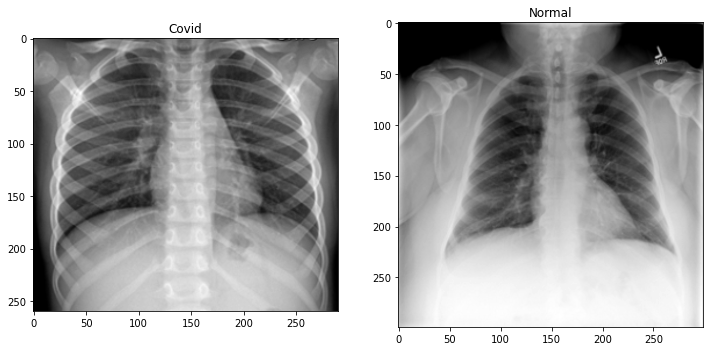

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
plt.imshow(img_covid,cmap='gray')
plt.title('Covid')

ax2 = fig.add_subplot(122)
plt.imshow(img_normal,cmap='gray')
plt.title('Normal')

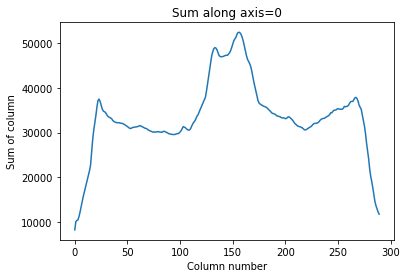

In [9]:
def eraseMax(img,eraseLineCenter=0,eraseLineWidth=30,draw=False):
    sumpix0=np.sum(img,0)
    if draw:
        plt.plot(sumpix0)
        plt.title('Sum along axis=0')
        plt.xlabel('Column number')
        plt.ylabel('Sum of column')
    max_r2=np.int_(len(sumpix0)/3)+np.argmax(sumpix0[np.int_(len(sumpix0)/3):np.int_(len(sumpix0)*2/3)])
    cv.line(img,(max_r2+eraseLineCenter,0),(max_r2+eraseLineCenter,512),0,eraseLineWidth)
    return img

img_erased = eraseMax(img_covid,draw=True)

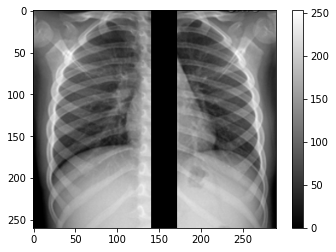

In [10]:
plt.imshow(img_erased,cmap='gray')
plt.colorbar()

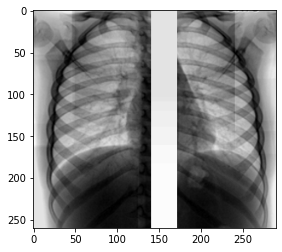

In [11]:
ker = 169
kernel = np.ones((ker,ker),np.uint8)
blackhat = cv.morphologyEx(img_erased, cv.MORPH_BLACKHAT, kernel)    
plt.imshow(blackhat,cmap='gray')

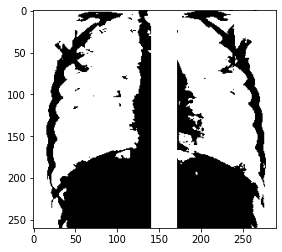

In [12]:
threshold = 75
ret, thresh = cv.threshold(blackhat, threshold, 255, 0)
plt.imshow(thresh,cmap='gray')

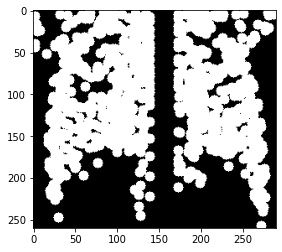

In [13]:
def get_cmask(img, maxCorners=900, qualityLevel=0.001, minDistance=1,Cradius=6):
    corners = cv.goodFeaturesToTrack(img, maxCorners, qualityLevel, minDistance)
    corners = np.int0(corners)
    cmask = np.zeros(img.shape)
    for corner in corners:
        x,y = corner.ravel()
        cv.circle(cmask,(x,y),Cradius,1,-1)
    return cmask

cmask = get_cmask(img_erased)
plt.imshow(cmask,cmap='gray')

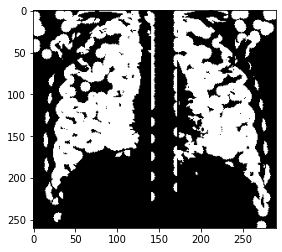

In [14]:
mask = np.multiply(cmask,thresh).astype('uint8')
plt.imshow(mask,cmap='gray')

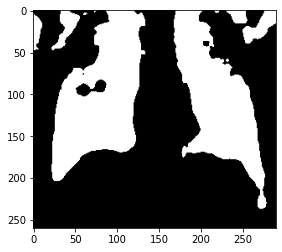

In [15]:
median = cv.medianBlur(mask,23) 
plt.imshow(median,cmap='gray')

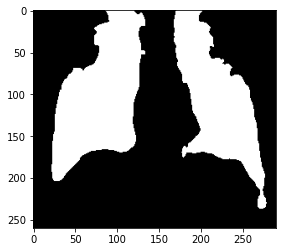

In [16]:
def contourMask(image):
    contours,hierc = cv.findContours(image,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE) 
    area = np.zeros(len(contours))
    for j in range(len(contours)):
        cnt = contours[j]
        area[j] = cv.contourArea(cnt)
    mask = np.zeros(image.shape)
    cv.drawContours(mask, contours, np.argmax(area), (255), -1)
    temp = np.copy(area[np.argmax(area)])
    area[np.argmax(area)]=0
    if area[np.argmax(area)] > temp/10:
        cv.drawContours(mask, contours, np.argmax(area), (255), -1)
    contours.clear() 
    return mask

contour_mask = contourMask(median).astype('uint8')
plt.imshow(contour_mask,cmap='gray')

In [17]:
contour_mask = cv.medianBlur(contour_mask,23)

Text(0.5, 1.0, 'Mask')

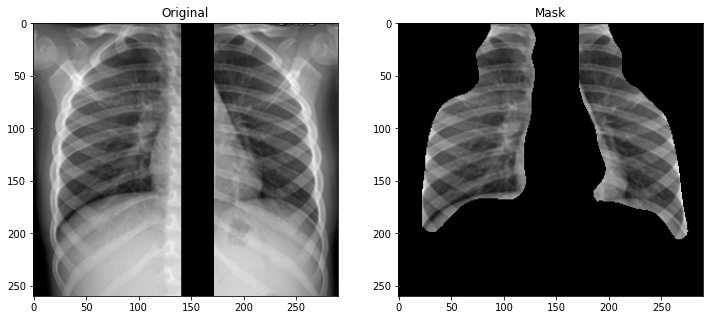

In [18]:
result = cv.bitwise_and(img_covid, contour_mask)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
plt.imshow(img_covid,cmap='gray')
plt.title('Original')

ax1 = fig.add_subplot(122)
plt.imshow(result,cmap='gray')
plt.title('Mask')

Text(0.5, 1.0, 'Mask')

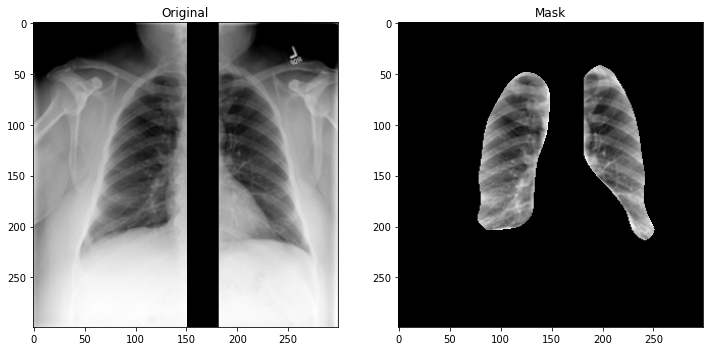

In [180]:
result = cv.bitwise_and(img_normal, contour_mask)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
plt.imshow(img_normal,cmap='gray')
plt.title('Original')

ax1 = fig.add_subplot(122)
plt.imshow(result,cmap='gray')
plt.title('Mask')

# Rede U-Net para segmentação de imagens
A partir das imagens e suas respectivas máscaras geradas pelo OpenCV, foi treinada uma rede neural U-Net para automatizar e melhorar a geração de máscaras, ao isolar a área dos pulmões nas imagens de Raio-X.

Referência: https://github.com/hlamba28/UNET-TGS

In [2]:
base_dir = r'C:\Users\lcroffi\Documents\estudo\Einstein\TCC\data'
img_dir = os.path.join(base_dir, 'imgs')
label_dir = os.path.join(base_dir, 'masks')

X_train_imgs = os.listdir(img_dir)
y_train_filenames = os.listdir(label_dir)

X_train_imgs.sort()
y_train_filenames.sort()

In [3]:
img_shape = (256, 256, 3)
batch_size = 3
X = np.zeros((len(X_train_imgs), img_shape[0], img_shape[1], 1), dtype=np.float32)
y = np.zeros((len(y_train_filenames), img_shape[0], img_shape[1], 1), dtype=np.float32)

In [4]:
for n, id_ in tqdm_notebook(enumerate(X_train_imgs), total=len(X_train_imgs)):
    # Load images
    img = image.load_img(img_dir+"\\"+id_, color_mode = "grayscale")
    x_img = image.img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = image.img_to_array(image.load_img(label_dir+"\\"+id_, color_mode = "grayscale"))
    mask = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

  0%|          | 0/4975 [00:00<?, ?it/s]

In [5]:
# Conjuntos de treinamento e validação
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

(-0.5, 255.5, 255.5, -0.5)

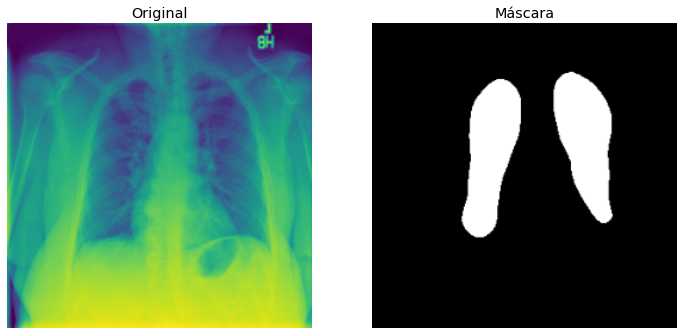

In [7]:
# Visualização de imagem aleatória e sua respectiva máscara
ix = random.randint(0, len(X_train))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8))
ax1.imshow(X_train[ix, ..., 0], cmap = 'viridis', interpolation = 'bilinear')
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Máscara')
ax2.axis('off')

In [6]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Função para adicionar 2 camadas convolucionais com os seus parâmetros"""
    # Primeira camada
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Segunda camada
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [7]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Função para definir o modelo U-Net"""
    # Contração
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansão
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [8]:
def dice_coeff(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [9]:
input_img = Input((img_shape[0], img_shape[1], 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_loss])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [10]:
model_path = '{}\\unet_lungs_dice.h5'.format(base_dir)
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(model_path, monitor = 'val_dice_loss', verbose=1, save_best_only=True, save_weights_only=True)
]

### Treinamento

In [11]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 4477 samples, validate on 498 samples
Epoch 1/50
4448/4477 [============================>.] - ETA: 6s - loss: 0.4334 - dice_loss: 0.2672 
Epoch 00001: val_dice_loss improved from inf to 0.59082, saving model to C:\Users\lcroffi\Documents\estudo\Einstein\TCC\data\unet_lungs_dice.h5
4477/4477 [==============================] - 960s 214ms/sample - loss: 0.4322 - dice_loss: 0.2664 - val_loss: 0.9235 - val_dice_loss: 0.5908
Epoch 2/50
4448/4477 [============================>.] - ETA: 6s - loss: 0.2490 - dice_loss: 0.1506 
Epoch 00002: val_dice_loss improved from 0.59082 to 0.24826, saving model to C:\Users\lcroffi\Documents\estudo\Einstein\TCC\data\unet_lungs_dice.h5
4477/4477 [==============================] - 966s 216ms/sample - loss: 0.2488 - dice_loss: 0.1504 - val_loss: 0.4096 - val_dice_loss: 0.2483
Epoch 3/50
4448/4477 [============================>.] - ETA: 6s - loss: 0.2193 - dice_loss: 0.1284 
Epoch 00003: val_dice_loss improved from 0.24826 to 0.19095, saving model to C:

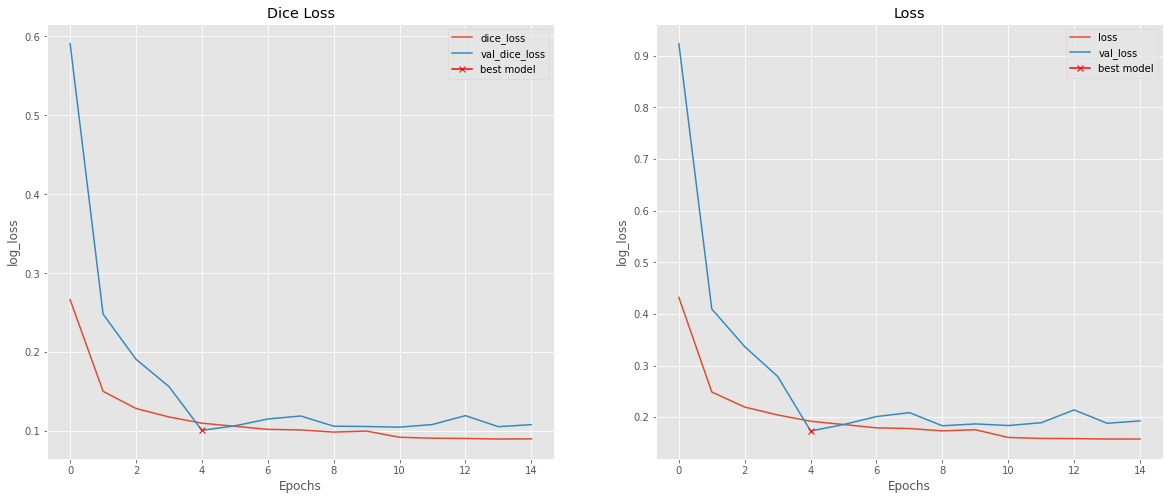

In [20]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Dice Loss")
plt.plot(history.history["dice_loss"], label="dice_loss")
plt.plot(history.history["val_dice_loss"], label="val_dice_loss")
plt.plot( np.argmin(history.history["val_dice_loss"]), np.min(history.history["val_dice_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

plt.show()

### Análise de resultados

In [32]:
model.load_weights(model_path)
model.save(f'{base_dir}\\unet_lungs_dice.hdf5')

In [33]:
model = models.load_model(f'{base_dir}\\unet_lungs_dice.hdf5', custom_objects={'bce_dice_loss': bce_dice_loss,
                                                      'dice_loss': dice_loss})

In [36]:
# Avaliação pelo conjunto de validação
loss, dice_loss = model.evaluate(X_valid, y_valid, verbose=1)

print("Loss: ", loss)
print("Dice Loss: ", dice_loss)

498/498 [==============================] - 14s 28ms/sample - loss: 0.1735 - dice_loss: 0.1018
Loss:  0.1735495520404065
Dice Loss:  0.10176505


In [37]:
# Predição no conjunto de treinamento e validação
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

498/498 [==============================] - 15s 29ms/sample


In [38]:
# Threshold nas estimativas
preds_train_t = (preds_train > 0.4).astype(np.uint8)
preds_val_t = (preds_val > 0.4).astype(np.uint8)

In [39]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Função para plotar os resultados"""
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='viridis')
    ax[0].set_title('Imagem Original')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask Original')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    ax[3].set_title('Predicted binary');

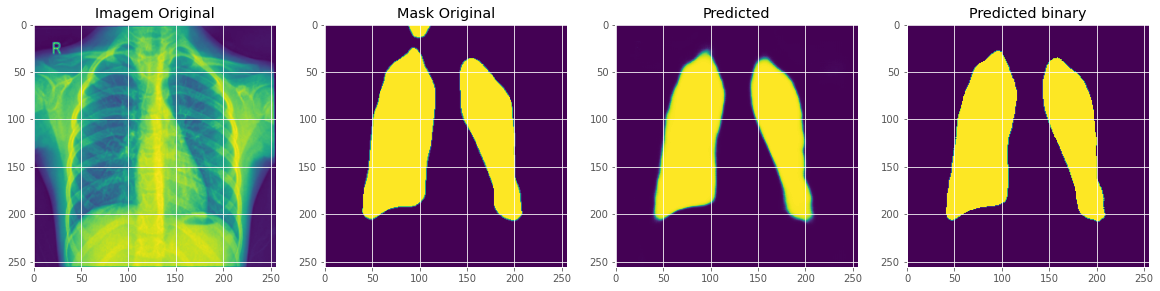

In [40]:
# Checar conjunto de treinamento
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=1000)

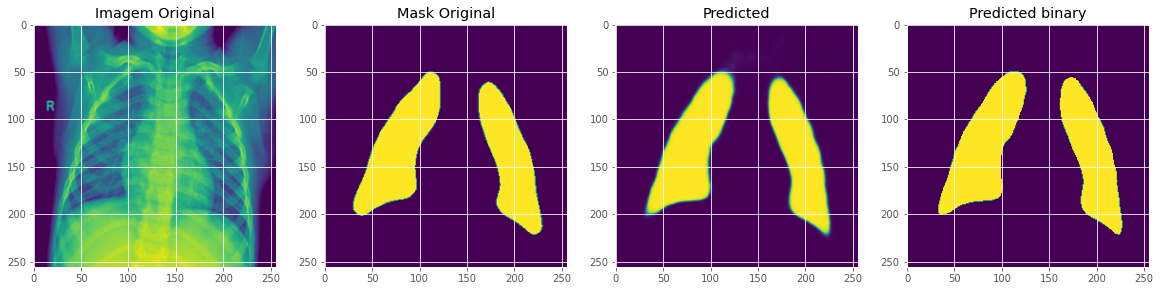

In [48]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

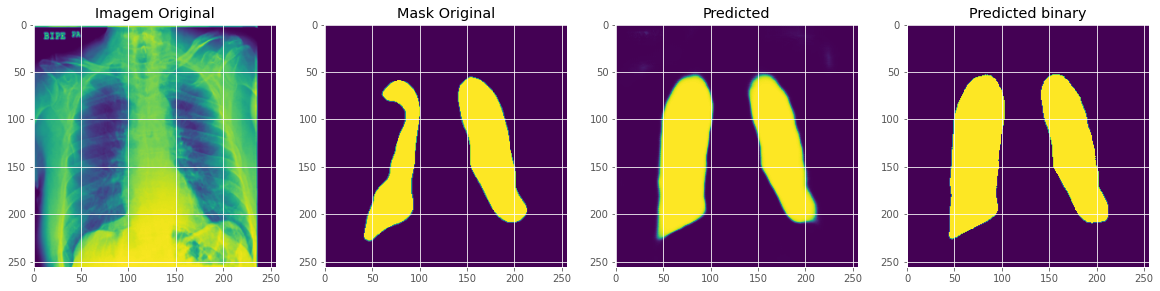

In [49]:
# Checar conjunto de teste
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

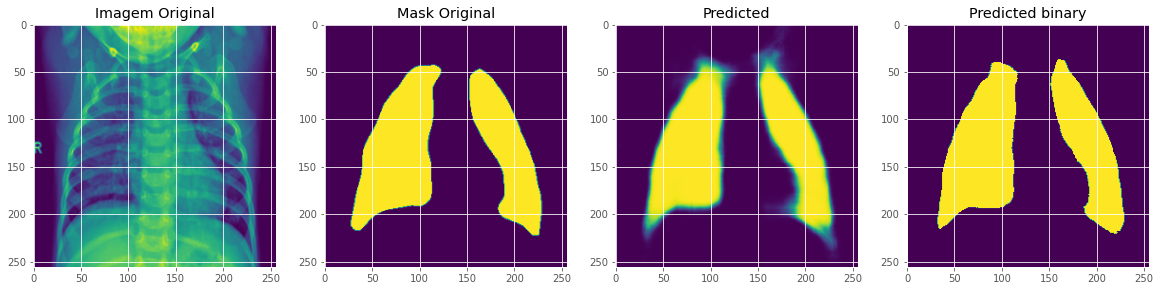

In [29]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

# CNN para classificação de Covid-19
As imagens com os pulmões recortados pelas máscaras foram colocadas em uma rede CNN para classificação de diagnóstico positivo ou negativo para Covid-19 resultando em uma acurácia balanceada de 83.13%.

In [2]:
base_dir = r'C:\Users\lcroffi\Documents\estudo\Einstein\TCC\data\mask_unet\data'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')

In [4]:
batch_size = 32
img_width, img_height = 250, 250
epochs = 100

In [22]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', padding = 'same', input_shape=(250, 250, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    
    optimizer = Adam(lr=1e-4)
    metrics=['accuracy']
    model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=metrics)
    return model

In [23]:
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                    shear_range = 0.2, 
                                    zoom_range = 0.2, 
                                    horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
 
training_set = train_datagen.flow_from_directory(train_dir,
                                                target_size = (img_width, img_height),
                                                batch_size = batch_size,
                                                class_mode = 'categorical')
                                                 
test_set = test_datagen.flow_from_directory(valid_dir,
                                            target_size = (img_width, img_height),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')
                                            
model = create_model()

model.summary()

Found 3446 images belonging to 2 classes.
Found 1532 images belonging to 2 classes.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 250, 250, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 31, 31, 64)        0         
____________________________________

In [24]:
filepath = fr'{base_dir}\cnn_lungs.h5'

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath, verbose=1, save_best_only=True, save_weights_only=True)
]

history = model.fit_generator(training_set,
                         steps_per_epoch=3446/batch_size,
                         epochs = epochs,
                         validation_data = test_set,
                         validation_steps = 1532/batch_size,
                         callbacks=callbacks)

Epoch 1/100
 48/107 [============>.................] - ETA: 20s - loss: 0.6066 - acc: 0.6893
Epoch 00001: val_loss improved from inf to 0.60817, saving model to C:\Users\lcroffi\Documents\estudo\Einstein\TCC\data\mask_unet\data\\cnn_lungs.h5
108/107 [==============================] - 129s 1s/step - loss: 0.6737 - acc: 0.5679 - val_loss: 0.6082 - val_acc: 0.6893
Epoch 2/100
 48/107 [============>.................] - ETA: 14s - loss: 0.5308 - acc: 0.7474
Epoch 00002: val_loss improved from 0.60817 to 0.53218, saving model to C:\Users\lcroffi\Documents\estudo\Einstein\TCC\data\mask_unet\data\\cnn_lungs.h5
108/107 [==============================] - 116s 1s/step - loss: 0.6093 - acc: 0.6849 - val_loss: 0.5322 - val_acc: 0.7474
Epoch 3/100
 48/107 [============>.................] - ETA: 13s - loss: 0.4941 - acc: 0.7670
Epoch 00003: val_loss improved from 0.53218 to 0.49543, saving model to C:\Users\lcroffi\Documents\estudo\Einstein\TCC\data\mask_unet\data\\cnn_lungs.h5
108/107 [=============

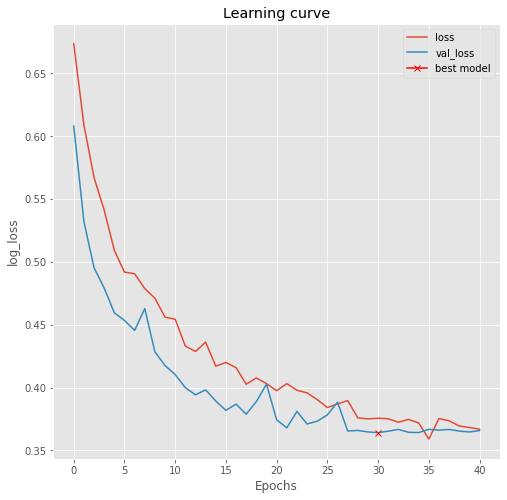

In [25]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


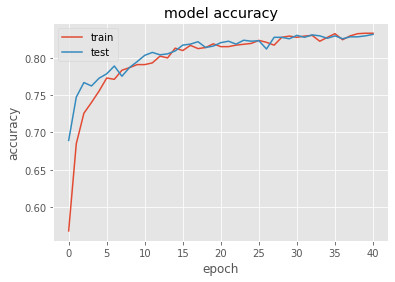

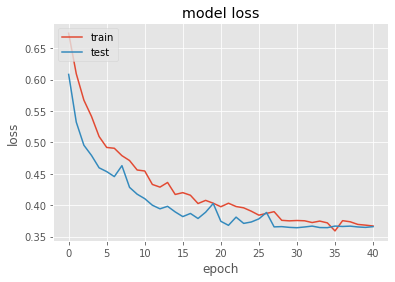

In [26]:
# listar todos os dados no history
print(history.history.keys())
# Gráfico de treino - acurácia
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Gráfico de treino - perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
        valid_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        shuffle=False)

test_steps_per_epoch = np.math.ceil(1532/batch_size)
predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)

predicted_classes = np.argmax(predictions, axis=1)
y_true = test_data_generator.classes
class_labels = test_data_generator.class_indices.keys()

Found 1532 images belonging to 2 classes.


In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
import seaborn as sns
c_matrix = confusion_matrix(y_true, predicted_classes)


Matriz de Confusão:



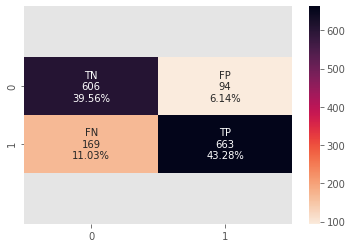


Balanced Accuracy : 0.8313

Classification Report : 
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       700
           1       0.88      0.80      0.83       832

    accuracy                           0.83      1532
   macro avg       0.83      0.83      0.83      1532
weighted avg       0.83      0.83      0.83      1532



In [66]:
# Imprimindo a Confusion Matrix, a métrica f1 e Classification Report
print('\nMatriz de Confusão:\n')
group_names = ['TN','FP','FN','TP']
group_counts = ['{0:0.0f}'.format(value) for value in c_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in c_matrix.flatten()/np.sum(c_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(c_matrix, annot=labels, fmt='', cmap='rocket_r')
i, m = plt.ylim()
i += 0.9
m += -0.9
plt.ylim(i, m)
plt.show()
print('\nBalanced Accuracy : %.4f' % balanced_accuracy_score(y_true, predicted_classes))
print()
print('Classification Report : ')
print(classification_report(y_true, predicted_classes))

Diagnóstico:  Normal


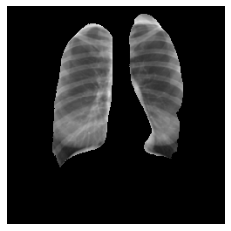

In [119]:
test_image = image.load_img(valid_dir + '\\normal\\Normal-2875.png', target_size = (250, 250))
plt.imshow(test_image)
plt.axis('off')
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

if result[0][1] == 0:
    estimativa = 'Covid-19'
else:
    estimativa = 'Normal'
    
print ('Diagnóstico: ', estimativa)

Diagnóstico:  Covid-19


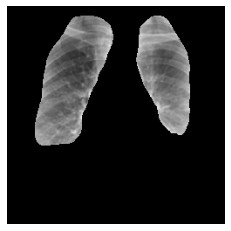

In [118]:
test_image = image.load_img(valid_dir + '\\covid\\COVID-3453.png', target_size = (250, 250))
plt.imshow(test_image)
plt.axis('off')
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

if result[0][1] == 0:
    estimativa = 'Covid-19'
else:
    estimativa = 'Normal'
    
print ('Diagnóstico: ', estimativa)